In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
#######
import sklearn.cluster
from sklearn.metrics.pairwise import euclidean_distances
import sklearn.metrics
import sklearn.linear_model

In [2]:
class RBFNetwork(object):
    """Rede Neural com Funções de Base Radial com uma única camada oculta.
    
    Essa é uma rede com três camadas.
        1) Camada de Entrada: Recebe os atributos usados como input.
        2) Camada Oculta: Aplica transformações não lineares sobre os dados
        de entrada, dadas pelo kernel para cada um dos centróides,
        ampliando o espaço de entrada para o espaço da rede oculta.
        3) Camada de Saída: Realiza a combinação linear das saídas da Camada
        Oculta.
        
    TREINAMENTO:
    Essa implementação utiliza o Kernel Gaussiano para a transformação da 
    camada oculta. São escolhidos number_of_centers centroides através do 
    K-Means sobre os dados de treinamento, com K = number_of_centers. 
    Para a execução do K-Means, foi utilizada a implementação do 
    sklearn.cluster.KMeans, iniciado com n_clusters = self.number_of_centers e
    random_state = self.random_state.

    Após o fit do KMeans, obteu-se os centros das agregações e, para
    cada agregação, o desvio padrão entre as observações daquela agregação
    e seu centro.

    Com esses valores, criou-se number_of_centers funções gaussianas, 
    centradas nos centros encontrados e com o parâmetro sigma igual ao
    desvio padrão.

    Em seguida, os dados de entrada são transformados para o espaço da camada
    oculta, aplicando o kernel para cada uma das observações. Por precaução,
     transforma-se os valores nan em 0. Esses dados são armazenados numa nova
     features_array, que representa os valores na Camada Oculta.

    Para realizar o ajuste dos pesos entre a Camada Oculta e a Camada de Saída,
    composta de um único neurônio, utilizou-se a classe do scikit-learn
    sklearn.linear_model.LinearRegression, com a features_array e os valores de
    y.

    PREDIÇÕES
    Uma vez que a classe esteja treinada, as predições são realizadas da seguinte
    forma:
        1) Transforma-se os valores de entrada para a Camada Oculta(features_array) utilizando
        os kernels calculados no treinamento.
        2) Utiliza-se os valores da Camada Oculta como entrada para o regressor
        linear treinado(sklearn.linear_model.LinearRegression).
        3) Retorna o resultado da regressão linear.
    
    Parameters
    ----------
    number_of_centers: integer, required
        O número de centróides/neurônios que existirão na Camada Oculta.
    random_state: integer, optional, default = 42
        Determina o número usado para o estado aleatório do K=Means.
    """

    def __init__(self, number_of_centers, random_state=42):
        """[summary]
                
        Arguments:
            number_of_centers {integer} -- The number of the centers
        
        Keyword Arguments:
            random_state {int} -- Random state, to be used with the internal algorithms (default: {42})
        """        

        self.number_of_centers = number_of_centers
        self.centers = None
        self.centers_std = None
        self.kernels = None
        self.random_state = random_state
        # Usado para fazer o ajuste linear após a alteração do espaço de entrada
        self.algorithm = sklearn.linear_model.LinearRegression()

    @staticmethod
    def make_gaussian_kernel(center, sigma):
        ''' Creates a Gaussian Kernel function that takes X and calculate the
        distance from the center with the sigma deviation. 
        '''
        variance = sigma**2
        if(variance == 0):
             variance = 1e-10
        gamma = 2*(variance)
        reshaped_center = np.reshape(center, newshape=(1, -1))

        def gaussian(X):
            dist = euclidean_distances(X, reshaped_center, squared=True)
            normalization_constant = 1/(2*np.pi*variance)
            return normalization_constant * np.exp(-(dist/gamma))
        return gaussian

    def fit(self, X, y):
        """
        Faz o ajuste da rede artificial RBF. 

        
        Essa implementação utiliza o Kernel Gaussiano para a transformação da 
        camada oculta. São escolhidos number_of_centers centroides através do 
        K-Means sobre os dados de treinamento, com K = number_of_centers. 
        Para a execução do K-Means, foi utilizada a implementação do 
        sklearn.cluster.KMeans, iniciado com n_clusters = self.number_of_centers e
        random_state = self.random_state.

        Após o fit do KMeans, obteu-se os centros das agregações e, para
        cada agregação, o desvio padrão entre as observações daquela agregação
        e seu centro.

        Com esses valores, criou-se number_of_centers funções gaussianas, 
        centradas nos centros encontrados e com o parâmetro sigma igual ao
        desvio padrão.

        Em seguida, os dados de entrada são transformados para o espaço da camada
        oculta, aplicando o kernel para cada uma das observações. Por precaução,
        transforma-se os valores nan em 0. Esses dados são armazenados numa nova
        features_array, que representa os valores na Camada Oculta.

        Para realizar o ajuste dos pesos entre a Camada Oculta e a Camada de Saída,
        composta de um único neurônio, utilizou-se a classe do scikit-learn
        sklearn.linear_model.LinearRegression, com a features_array e os valores de
        y.

        Parameters
        ----------
        X: Atributos fornecidos para o treinamento do algoritmo
        y: Valores alvo para o algoritmo.
        """
        self._fit_centers(X, y)
        self._generate_radial_functions()

        transformed_X = self._transformed_inputs(X)
        self._linear_fit(transformed_X, y)

    def predict(self, X):
        """Função usada para a predição dos valores.
    
        Uma vez que a classe esteja treinada, as predições são realizadas da seguinte
        forma:
            1) Transforma-se os valores de entrada para a Camada Oculta(features_array) utilizando
            os kernels calculados no treinamento.
            2) Utiliza-se os valores da Camada Oculta como entrada para o regressor
            linear treinado(sklearn.linear_model.LinearRegression).
            3) Retorna o resultado da regressão linear.
        
        Parameter
        ---------
        X: Atributos que alimentarão a Camada de Entrada.
        """
        transformed_X = self._transformed_inputs(X)
        return (self.algorithm.predict(transformed_X))

    def _fit_centers(self, X, y=None):
        """Essa função obtem o centróides e os desvios padrão utilizados
        para calcular os kernels."""
        kmeans = sklearn.cluster.KMeans(n_clusters=self.number_of_centers,
                                        random_state=self.random_state)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_
        groups = kmeans.predict(X)

        center_distances = euclidean_distances(X, self.centers)
        center_distances_df = pd.DataFrame(center_distances)
        center_distances_df['classe'] = groups

        # Calculate the std from the center
        # Note that the center_distances_df has the distance from each center
        center_distances_std = center_distances_df.groupby('classe').std()
        self.centers_std = np.diag(center_distances_std)

    def _generate_radial_functions(self):
        """Essa função cria a lista de kernels usada para gerar a Camada Oculta."""
        self.kernels = list()
        for cluster_center, cluster_deviance in zip(self.centers, self.centers_std):
            kernel = self.make_gaussian_kernel(
                cluster_center, cluster_deviance)#mexi aqui
            self.kernels.append(kernel)

    def _transformed_inputs(self, X):
        """Transforma os dados do Espaço de Entrada para o Espaço da Camada Oculta.
        
        Essa função aplica os kernels da RBFN nos dados de entrada, criando uma array
        que representa os valores na camada oculta.

        Parameters
        ----------
        X: Valores dos atributos de entrada, que deverão ser convertidos para 
        valores na camada oculta pelas funções de kernel.
        """
        features = [kernel(X) for kernel in self.kernels]
        features_array = (np.concatenate(features, axis=1))
        features_array = np.nan_to_num(x = features_array) # mexi aqui
        return features_array

    def _linear_fit(self, hidden_X, y):
        """Realiza o ajuste dos pesos que ligam a Camada Oculta à Camada De Saída.
        
        O ajuste é realizado através do algoritmo sklearn.linear_model.LinearRegression.
        
        Parameters
        ----------
        hidden_X: Os valores da Camada Oculta, ou seja, os valores de entrada
        transformados para a camada oculta. Seja X a matriz que contém os valores
        que entram na Camada de Entrada: 
            hidden_X = _self._transformed_inputs(X) """
        self.algorithm.fit(hidden_X, y)


In [3]:
db = pd.read_csv("C:/Users/thale/Desktop/Faculdade_e_Trabalho/IC/IC2019/CoronaVirus/SpaCovid-19.csv")
log = lambda x: math.log2(x)
deslog = lambda x: 2**x
Xsp= db.drop('Y',axis=1)
Xsp=Xsp.applymap(log)
ysp= db['Y']
ysp=ysp.apply(log)
db

,covid1,covid2,covid3,covid4,covid5,covid6,Y
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2
4,1,1,1,1,1,2,2
5,1,1,1,1,2,2,2
6,1,1,1,2,2,2,2
7,1,1,2,2,2,2,2
8,1,2,2,2,2,2,2
9,2,2,2,2,2,2,2


In [4]:
rbfNetwork = RBFNetwork(3)
#for i in range(0,10):
rbfNetwork.fit(Xsp,ysp)

Predição Brasil


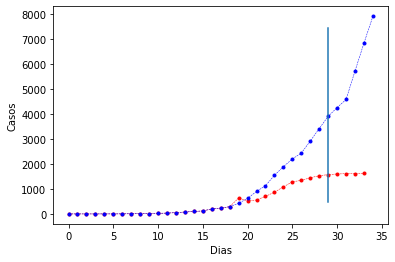

In [5]:
dbBr = pd.read_csv("C:/Users/thale/Desktop/Faculdade_e_Trabalho/IC/IC2019/CoronaVirus/Covid-19.csv")
xBr = dbBr.drop('Y', axis=1)
xBr= xBr.applymap(log)
yBr = dbBr['Y']
yBr= yBr.apply(log)
for i in range(0,15):
    linha = xBr.loc[(13+i)]
    Ypred = rbfNetwork.predict([linha])
    xBr.at[(14+i),'cases6']=Ypred
    xBr.at[(15+i),'cases5']=Ypred
    xBr.at[(16+i),'cases4']=Ypred
    xBr.at[(17+i),'cases3']=Ypred
    xBr.at[(18+i),'cases2']=Ypred
    xBr.at[(19+i),'cases1']=Ypred
xBr = xBr.applymap(deslog)
lista1 = []
lista2 = []
for i in range(0,35):
    if(i<34):
        lista1.append(i)
    lista2.append(i)
CovidBr = pd.read_csv("C:/Users/thale/Desktop/Faculdade_e_Trabalho/IC/IC2019//CoronaVirus/covid-19UmaColuna.csv")
plt.xlabel('Dias')
plt.ylabel('Casos')
plt.plot(lista1,xBr['cases1'],linestyle='--', color='r', marker='.', linewidth=0.5)
plt.plot(lista2,CovidBr['cases'],linestyle='--', color='b', marker='.', linewidth=0.5)
plt.axvline(x=29, ymin=0.1, ymax=0.9) #inicio da quarentena no brasil
print("Predição Brasil")

Predição Espanha


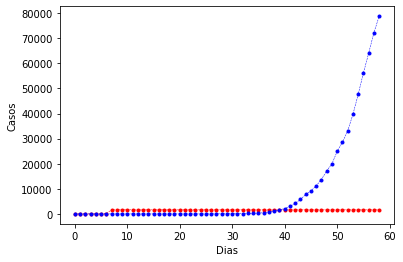

In [6]:
# prever dados da espanha
DadosSp=db.drop('Y',axis=1)
DadosSp= DadosSp.loc[0:1]
DadosSp = DadosSp.applymap(log)
for i in range(0,58):
    linha = DadosSp.loc[i]
    Ypred = rbfNetwork.predict([linha])
    DadosSp.at[(1+i),'covid6']=Ypred
    DadosSp.at[(1+i),'covid5']=DadosSp.loc[i,['covid6']]
    DadosSp.at[(1+i),'covid4']=DadosSp.loc[i,['covid5']]
    DadosSp.at[(1+i),'covid3']=DadosSp.loc[i,['covid4']]
    DadosSp.at[(1+i),'covid2']=DadosSp.loc[i,['covid3']]
    DadosSp.at[(1+i),'covid1']=DadosSp.loc[i,['covid2']]
DadosSp = DadosSp.applymap(deslog) 
lista3 =[]
for i in range(0,59):
    lista3.append(i)
plt.xlabel('Dias')
plt.ylabel('Casos')
plt.plot(lista3,DadosSp['covid1'],linestyle='--', color='r', marker='.', linewidth=0.5)
plt.plot(lista3,db['covid1'],linestyle='--', color='b', marker='.', linewidth=0.5)

# comparar com dados 
# 20 50 100 neuronios, 3 5 e 10 camadas
print("Predição Espanha")

% Vai fazer uma comparação entre três regressores: MLP, RBF, regressão linear

% Seção ou Subseção: resultados com dados da radiação Solar

% Seção ou Subseção: resultados com dados da Covid-19

% Média de 10 simulações - Erro quadrático e variância

In [7]:
print(rbfNetwork.centers_std)

[2.38609913 2.04240936 1.76086831]
